In [100]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import shap
import pandas as pd
import pprint
import time
import re
import nltk.corpus

shap.initjs()

# Import news data

In [129]:
url = 'https://raw.githubusercontent.com/JessieJessJe/COVIDsentiment/master/covid_news.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [130]:
df = df.drop(columns='Unnamed: 0')

In [131]:
df = df.fillna('null')

In [132]:
df = df[df.source != 'null']

In [133]:
df

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'wired', 'name': 'Wired'}",Gilad Edelman,The Analogy Between Covid-19 and Climate Chang...,"First deny the problem, then say the solution ...",https://www.wired.com/story/the-analogy-betwee...,https://media.wired.com/photos/5e7ba5188283f90...,2020-03-25T18:59:54Z,"For a brief moment there, it looked as though ..."
1,"{'id': 'the-verge', 'name': 'The Verge'}",Russell Brandom,Relaxing isolation rules won’t help the econom...,President Donald Trump has pushed to relax soc...,https://www.theverge.com/2020/3/25/21193670/tr...,https://cdn.vox-cdn.com/thumbor/0Tupek3aPuU95P...,2020-03-25T12:36:51Z,President Trump is pushing to ease restriction...
2,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Natasha Lomas,TripActions reportedly lays off hundreds amid ...,The coronavirus demand crunch has taken anothe...,http://techcrunch.com/2020/03/25/tripactions-r...,https://techcrunch.com/wp-content/uploads/2020...,2020-03-25T11:10:36Z,The coronavirus demand crunch has taken anothe...
3,"{'id': None, 'name': 'Gizmodo.com'}","Brian Kahn and Dhruv Mehrotra on Earther, shar...",Coronavirus Has Slashed Global Air Pollution. ...,"The covid-19 pandemic has changed the world, g...",https://earther.gizmodo.com/coronavirus-slashe...,https://i.kinja-img.com/gawker-media/image/upl...,2020-03-25T12:53:00Z,"The covid-19 pandemic has changed the world, g..."
4,"{'id': None, 'name': 'Gizmodo.com'}",Tom McKay,Twitter Deletes Post by The Federalist Calling...,Twitter has removed a tweet from the right-win...,https://gizmodo.com/twitter-deletes-post-by-th...,https://i.kinja-img.com/gawker-media/image/upl...,2020-03-25T23:15:00Z,Twitter has removed a tweet from the right-win...
...,...,...,...,...,...,...,...,...
997,"{'id': None, 'name': 'Vox.com'}",Sean Collins,Rep. Devin Nunes recommended going out despite...,"Listen to coronavirus experts, not elected off...",https://www.vox.com/policy-and-politics/2020/3...,https://cdn.vox-cdn.com/thumbor/iAG48sMVWFK9QO...,2020-03-16T17:00:00Z,"Rep. Devin Nunes (D-CA) in Washington, DC, on ..."
998,"{'id': None, 'name': 'Vox.com'}",Jen Kirby,US and Europe have a new normal: Monday’s coro...,And what you might have missed over the weekend.,https://www.vox.com/2020/3/16/21180634/coronav...,https://cdn.vox-cdn.com/thumbor/4r6X9cWtOErp1C...,2020-03-16T15:40:00Z,"The 110 freeway in downtown Los Angeles, Calif..."
999,"{'id': None, 'name': 'Vox.com'}",Matthew Yglesias,Democrats’ choice is clearer than ever: Fight ...,Bernie Sanders’s and Joe Biden’s differing app...,https://www.vox.com/2020/3/15/21180998/march-d...,https://cdn.vox-cdn.com/thumbor/lh13KbaNul5YQ9...,2020-03-16T02:50:00Z,Joe Biden and Sen. Bernie Sanders at the Democ...
1000,"{'id': None, 'name': 'Vox.com'}",Ian Millhiser,The fake text message about the “Stafford Act”...,Don’t believe everything you read online.,https://www.vox.com/2020/3/16/21181486/staffor...,https://cdn.vox-cdn.com/thumbor/T1tZ_7pWvTpBzG...,2020-03-16T16:10:00Z,President Trump during a news conference in th...


# Using VADER to create sentiment label

In [134]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [135]:
def analyser_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [136]:
list_compound = []
list_label = []

for content in df.description:
    score = analyser_scores(content)
   
    if score > 0.05: 
        list_label.append(1)
        list_compound.append(score)
       
            
    elif score < -0.05: 
        list_label.append(0)
        list_compound.append(score)
        
    else:
        list_label.append('null') 

In [137]:
list_label

[0,
 0,
 0,
 'null',
 1,
 0,
 'null',
 1,
 1,
 0,
 'null',
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 'null',
 1,
 0,
 0,
 'null',
 1,
 1,
 0,
 'null',
 1,
 'null',
 1,
 'null',
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 'null',
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 'null',
 'null',
 1,
 0,
 0,
 0,
 'null',
 0,
 1,
 'null',
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 'null',
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 'null',
 1,
 0,
 0,
 'null',
 1,
 'null',
 0,
 0,
 'null',
 'null',
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 'null',
 'null',
 0,
 0,
 1,
 0,
 0,
 'null',
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 'null',
 1,
 0,
 'null',
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 'null',
 1,
 1,
 1,
 0,
 1,
 0,
 'null',
 0,
 1,
 'null',
 0,
 0,
 'null',
 0,
 'null',
 1,
 0,
 1,
 0,
 'null',
 0,
 0,
 1,
 1,
 1,
 0,
 'null',
 'null',
 'null',
 0,
 0,
 1,
 1,
 'null',
 'null',
 'null',
 0,
 1,
 0,
 'null',
 0,
 1,
 0,
 1,
 1,
 0,
 'null',
 1,
 1,
 0,
 1,
 'null',
 0,
 'null',
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 'null',
 0,
 0,
 'null',
 0,
 0,
 1,
 'null',
 1,
 0,
 'null',
 0,
 0,
 'null',
 0,
 0,
 0,
 0,
 'null',
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 'null',
 1,
 0,
 'null',
 'null',
 0,
 0,
 1,
 1,
 'null',
 'null',
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 'null',
 0,
 1,
 'null',
 1,
 'null',
 'null',
 0,
 'null',
 1,
 'null',
 0,
 'null',
 1,
 0,
 1,
 1,
 0,
 'null',
 0,
 1,
 1,
 1,
 'null',
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 'null',
 0,
 0,
 0,
 'null',
 0,
 1,
 0,
 1,
 0,
 'null',
 0,
 0,
 'null',
 0,
 1,
 1,
 0,
 1,
 'null',
 0,
 1,
 1,
 0,
 1,
 'null',
 'null',
 'null',
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 'null',
 0,
 'null',
 1,
 1,
 'null',
 'null',
 0,
 1,
 0,
 'null',
 0,
 0,
 'null',
 'null',
 0,
 1,
 0,
 'null',
 'null',
 'null',
 0,
 1,
 0,
 1,
 'null',
 1,
 0,
 'null',
 'null',
 1,
 0,
 'null',
 'null',
 'null',
 1,
 0,
 1,
 0,
 1,
 'null',
 'null',
 0,
 0,
 1,
 0,
 1,
 1,
 'null',
 'null',
 1,
 1,
 0,
 0,
 0,
 0,
 'null',
 0,
 1,
 'null',
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 'null',
 1,
 1,
 0,
 'null',
 'null',
 'null',
 0,
 'null',
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 'null',
 'null',
 1,
 'null',
 1,
 1,
 1,
 'null',
 'null',
 1,
 'null',
 1,
 'null',
 0,
 0,
 1,
 0,
 0,
 'null',
 0,
 0,
 'null',
 1,
 0,
 'null',
 1,
 0,
 0,
 0,
 'null',
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 'null',
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 'null',
 0,
 0,
 'null',
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 'null',
 0,
 0,
 1,
 'null',
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 'null',
 'null',
 0,
 1,
 0,
 0,
 0,
 'null',
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 'null',
 1,
 0,
 0,
 0,
 0,
 'null',
 0,
 0,
 1,
 'null',
 0,
 'null',
 0,
 0,
 0,
 0,
 'null',
 0,
 0,
 1,
 1,
 0,
 'null',
 0,
 1,
 0,
 1,
 'null',
 0,
 0,
 0,
 1,
 1,
 0,
 'null',
 0,
 0,
 'null',
 'null',
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 'null',
 'null',
 0,
 1,
 'null',
 1,
 'null',
 1,
 0,
 1,
 'null',
 1,
 'null',
 0,
 1,
 1,
 0,
 1,
 0,
 'null',
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 'null',
 1,
 1,
 'null',
 0,
 0,
 0,
 'null',
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 'null',
 1,
 0,
 0,
 0,
 'null',
 1,
 0,
 0,
 'null',
 0,
 1,
 1,
 1,
 'null',
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 'null',
 1,
 'null',
 1,
 'null',
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 'null',
 'null',
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 'null',
 'null',
 0,
 1,
 1,
 1,
 0,
 'null',
 1,
 0,
 1,
 0,
 0,
 'null',
 'null',
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 'null',
 'null',
 'null',
 1,
 'null',
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 'null',
 0,
 'null',
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 'null',
 'null',
 1,
 'null',
 'null',
 1,
 0,
 0,
 'null',
 0,
 0,
 0,
 0,
 'null',
 0,
 1,
 0,
 'null',
 0,
 'null',
 0,
 1,
 'null',
 0,
 1,
 'null',
 'null',
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 'null',
 'null',
 1,
 1,
 0,
 0,
 'null',


In [138]:
len(list_compound)

793

In [139]:
list_compound

[-0.4215,
 -0.4939,
 -0.4939,
 0.5267,
 -0.9217,
 0.4404,
 0.5574,
 -0.4404,
 -0.6369,
 0.079,
 -0.128,
 0.5859,
 0.5574,
 -0.3612,
 0.4404,
 -0.2023,
 -0.6705,
 -0.6369,
 -0.2732,
 0.1779,
 0.5187,
 -0.7003,
 -0.296,
 0.743,
 0.1022,
 -0.3071,
 0.836,
 0.128,
 0.6187,
 -0.1027,
 -0.1154,
 -0.4215,
 -0.0516,
 -0.6808,
 0.8689,
 0.9432,
 -0.3182,
 0.3182,
 -0.9169,
 0.3182,
 0.4588,
 0.7096,
 -0.4767,
 0.128,
 0.1027,
 0.1027,
 0.7964,
 -0.6597,
 0.4404,
 -0.5423,
 -0.4019,
 -0.5843,
 -0.9153,
 0.4404,
 0.4404,
 0.5023,
 0.128,
 -0.0772,
 0.5574,
 0.6705,
 -0.25,
 -0.4417,
 -0.2023,
 -0.8059,
 -0.3182,
 -0.9169,
 -0.4019,
 0.6808,
 -0.4019,
 -0.296,
 -0.4767,
 -0.6249,
 0.5994,
 -0.4939,
 0.5859,
 -0.4939,
 0.4767,
 -0.2023,
 -0.875,
 0.4019,
 -0.6705,
 -0.4019,
 0.2382,
 -0.2732,
 0.4877,
 -0.25,
 -0.5574,
 -0.9136,
 -0.8591,
 -0.659,
 -0.5267,
 0.5994,
 -0.6808,
 0.34,
 -0.4215,
 -0.5972,
 0.4404,
 -0.6597,
 -0.3818,
 0.2023,
 -0.7906,
 0.3612,
 0.8176,
 0.3818,
 0.8402,
 -0.3818,
 -0.6956,
 -0.9246,
 0.1877,
 -0.2023,
 -0.4215,
 0.0772,
 -0.128,
 -0.1477,
 -0.6249,
 -0.4404,
 -0.8316,
 -0.0516,
 0.5267,
 0.3612,
 0.4218,
 -0.5267,
 0.5913,
 -0.0964,
 -0.6249,
 0.4767,
 -0.296,
 -0.6486,
 -0.34,
 0.4215,
 -0.9325,
 0.6705,
 -0.5267,
 -0.1531,
 -0.5994,
 0.8816,
 0.5106,
 0.3975,
 -0.8689,
 -0.2484,
 -0.0516,
 0.3818,
 0.6908,
 -0.5106,
 0.1779,
 -0.34,
 -0.5994,
 0.3612,
 -0.25,
 0.644,
 0.4215,
 -0.4019,
 0.4572,
 0.5106,
 -0.0772,
 0.0772,
 -0.2263,
 -0.5994,
 0.5106,
 -0.5994,
 0.7665,
 -0.7964,
 0.6124,
 -0.5635,
 0.2732,
 0.0516,
 -0.1531,
 -0.4404,
 -0.7822,
 -0.0516,
 -0.7717,
 -0.34,
 0.1027,
 0.4019,
 -0.3089,
 -0.8056,
 -0.6908,
 -0.5267,
 -0.7425,
 -0.3818,
 -0.34,
 -0.5423,
 0.3818,
 0.7832,
 0.4767,
 -0.4019,
 -0.1531,
 -0.3892,
 0.4767,
 -0.8126,
 -0.3182,
 -0.866,
 0.7595,
 0.3612,
 -0.6808,
 -0.6369,
 0.25,
 0.6705,
 -0.4939,
 -0.296,
 0.7184,
 -0.468,
 0.2263,
 0.7522,
 -0.25,
 -0.1901,
 0.5106,
 0.1027,
 -0.296,
 0.34,
 -0.9094,
 0.4404,
 -0.296,
 0.4215,
 0.1531,
 -0.3182,
 -0.2732,
 0.8805,
 0.3499,
 0.1027,
 -0.8689,
 0.2732,
 0.1027,
 -0.0772,
 0.6597,
 -0.6705,
 0.4404,
 -0.34,
 -0.8679,
 0.5267,
 0.3818,
 -0.6486,
 0.3612,
 -0.8176,
 -0.4404,
 -0.7269,
 -0.3994,
 -0.891,
 -0.3182,
 0.8016,
 -0.1779,
 0.296,
 -0.4767,
 -0.9764,
 -0.4939,
 -0.981,
 0.7096,
 0.4209,
 -0.1027,
 0.4019,
 -0.9689,
 0.2732,
 0.4215,
 -0.4019,
 0.0772,
 0.1027,
 -0.5423,
 -0.34,
 -0.6249,
 -0.7311,
 0.1027,
 0.1901,
 0.4215,
 -0.0772,
 0.0772,
 0.3612,
 -0.3612,
 0.4215,
 -0.4404,
 -0.6705,
 -0.296,
 -0.3182,
 0.6538,
 -0.5483,
 -0.3818,
 0.2732,
 -0.6597,
 0.4404,
 0.4118,
 -0.34,
 0.5423,
 -0.8225,
 0.2023,
 -0.2144,
 0.1531,
 -0.6249,
 0.0772,
 -0.296,
 -0.4939,
 0.0772,
 -0.4019,
 0.7003,
 0.5423,
 0.4767,
 0.1531,
 -0.9701,
 -0.875,
 -0.9552,
 -0.2047,
 -0.8271,
 0.3664,
 0.34,
 -0.8779,
 0.2023,
 0.802,
 -0.1901,
 0.8688,
 -0.5267,
 0.2023,
 0.4215,
 -0.6486,
 -0.6249,
 0.4019,
 -0.1119,
 -0.4019,
 -0.5859,
 0.1531,
 -0.4215,
 -0.7506,
 -0.9206,
 -0.5267,
 0.5267,
 -0.3919,
 -0.6486,
 -0.3818,
 -0.8807,
 -0.5423,
 -0.1027,
 -0.6486,
 -0.7964,
 0.2748,
 0.2023,
 0.2617,
 0.836,
 0.2177,
 0.1027,
 0.25,
 -0.5423,
 -0.4215,
 0.2617,
 -0.7184,
 -0.3753,
 -0.3089,
 -0.6249,
 0.5994,
 -0.4215,
 0.5499,
 -0.5994,
 -0.0516,
 -0.0516,
 -0.6124,
 -0.25,
 0.8415,
 0.0772,
 -0.5267,
 0.3818,
 0.8481,
 0.4404,
 -0.4215,
 0.5267,
 0.0762,
 0.2263,
 0.3818,
 0.6461,
 0.25,
 -0.3182,
 -0.2023,
 -0.3818,
 -0.2023,
 -0.3182,
 0.4902,
 -0.2732,
 0.7906,
 -0.659,
 -0.7845,
 -0.5106,
 0.6249,
 -0.7251,
 -0.8519,
 -0.5423,
 0.1027,
 0.1779,
 -0.7096,
 0.7264,
 -0.7907,
 -0.3643,
 0.4215,
 -0.6249,
 0.1531,
 0.6808,
 0.4562,
 -0.5267,
 0.296,
 0.2846,
 -0.624,
 -0.4268,
 0.5719,
 -0.3818,
 -0.5719,
 0.704,
 -0.9042,
 -0.2023,
 -0.4939,
 0.6486,
 0.7506,
 -0.4939,
 0.4588,
 -0.6486,
 -0.4404,
 -0.296,
 -0.7269,
 -0.0772,
 0.296,
 -0.1027,
 -0.3071,
 -0.8402,
 0.6597,
 0.6597,
 -0.1901,
 -0.7862,
 -0.5719,
 -0.7845,
 0.1779,
 0.4417,
 -0.4215,
 

In [140]:
#adding label to the dataset    
df['sentiment']= list_label
df = df[df.sentiment != 'null']

# Visualize the sentiment distribution

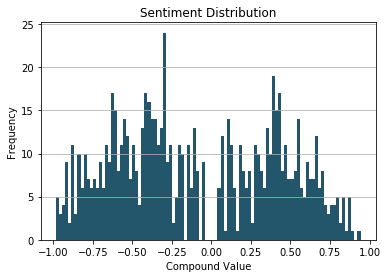

In [114]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=list_compound, bins=100, color='#24566B')
                        

plt.grid(axis='y', alpha=10)

plt.xlabel('Compound Value')
plt.ylabel('Frequency')

plt.title('Sentiment Distribution')
print()

In [115]:
df.head()

,source,author,title,description,url,urlToImage,publishedAt,content,sentiment
0,"{'id': 'wired', 'name': 'Wired'}",Gilad Edelman,The Analogy Between Covid-19 and Climate Chang...,"First deny the problem, then say the solution ...",https://www.wired.com/story/the-analogy-betwee...,https://media.wired.com/photos/5e7ba5188283f90...,2020-03-25T18:59:54Z,"For a brief moment there, it looked as though ...",0
1,"{'id': 'the-verge', 'name': 'The Verge'}",Russell Brandom,Relaxing isolation rules won’t help the econom...,President Donald Trump has pushed to relax soc...,https://www.theverge.com/2020/3/25/21193670/tr...,https://cdn.vox-cdn.com/thumbor/0Tupek3aPuU95P...,2020-03-25T12:36:51Z,President Trump is pushing to ease restriction...,0
2,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Natasha Lomas,TripActions reportedly lays off hundreds amid ...,The coronavirus demand crunch has taken anothe...,http://techcrunch.com/2020/03/25/tripactions-r...,https://techcrunch.com/wp-content/uploads/2020...,2020-03-25T11:10:36Z,The coronavirus demand crunch has taken anothe...,0
4,"{'id': None, 'name': 'Gizmodo.com'}",Tom McKay,Twitter Deletes Post by The Federalist Calling...,Twitter has removed a tweet from the right-win...,https://gizmodo.com/twitter-deletes-post-by-th...,https://i.kinja-img.com/gawker-media/image/upl...,2020-03-25T23:15:00Z,Twitter has removed a tweet from the right-win...,1
5,"{'id': None, 'name': 'Gizmodo.com'}",Ed Cara,The Truth of Coronavirus Might Be Worse Than t...,"The covid-19 pandemic is a disorienting, fast-...",https://gizmodo.com/the-truth-of-coronavirus-m...,https://i.kinja-img.com/gawker-media/image/upl...,2020-03-25T22:25:00Z,"The covid-19 pandemic is a disorienting, fast-...",0


# NLP pipeline

In [141]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Jessie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [142]:
train_data = df

In [143]:
cols_to_drop = ['source', 'author', 'title', 'url', 'urlToImage',
       'publishedAt', 'content']
train_data = train_data.drop(cols_to_drop, axis=1)

In [144]:
train_data.head()

,description,sentiment
0,"First deny the problem, then say the solution ...",0
1,President Donald Trump has pushed to relax soc...,0
2,The coronavirus demand crunch has taken anothe...,0
4,Twitter has removed a tweet from the right-win...,1
5,"The covid-19 pandemic is a disorienting, fast-...",0


In [145]:
def clean_text(df, new_content, content):
    df[new_content] = df[content].str.lower()
    df[new_content] = df[new_content].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_content] = df[new_content].apply(lambda elem: re.sub(r"\d+", "", elem))   
    return df

data_clean = clean_text(train_data,'description','description')

In [146]:
# removes stop words 
data_clean['description'] = data_clean['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [147]:
data_clean.sentiment.astype('int')
data_clean.head()
data_clean.to_csv('wyyy.csv')

# TF-IDF

In [151]:
X_train, X_test, y_train, y_test = train_test_split(data_clean['description'],data_clean['sentiment'],test_size=0.25, random_state = 0)
vectorizer = TfidfVectorizer(min_df=0.005)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [152]:
word = vectorizer.get_feature_names()
len(word)

939

In [96]:
# visualize the result of TFIDF

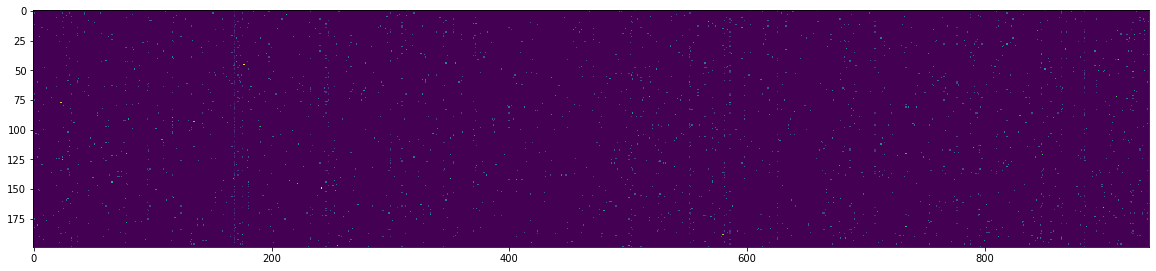

In [97]:
show = X_test.toarray()
plt.figure(figsize=(20,10))
plt.imshow(show[0:200,:])

# LR model

In [154]:
from sklearn.model_selection import GridSearchCV
lr = sklearn.linear_model.LogisticRegression()

grid_value = {'solver':['sag','liblinear','lbfgs'],
              'C': [0.01, 0.1, 1, 10]}

model_lr = GridSearchCV(lr, cv=10, param_grid=grid_value)

y_train=y_train.astype('int')
y_test=y_test.astype('int')

model_lr.fit(X_train, y_train)

#print results
means = model_lr.cv_results_['mean_test_score']
stds = model_lr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model_lr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

model_final = model_lr.best_estimator_

print()
print(model_lr.best_params_)

0.577 (+/-0.010) for {'C': 0.01, 'solver': 'sag'}
0.577 (+/-0.010) for {'C': 0.01, 'solver': 'liblinear'}
0.577 (+/-0.010) for {'C': 0.01, 'solver': 'lbfgs'}
0.577 (+/-0.010) for {'C': 0.1, 'solver': 'sag'}
0.577 (+/-0.010) for {'C': 0.1, 'solver': 'liblinear'}
0.577 (+/-0.010) for {'C': 0.1, 'solver': 'lbfgs'}
0.652 (+/-0.123) for {'C': 1, 'solver': 'sag'}
0.650 (+/-0.123) for {'C': 1, 'solver': 'liblinear'}
0.652 (+/-0.123) for {'C': 1, 'solver': 'lbfgs'}
0.682 (+/-0.124) for {'C': 10, 'solver': 'sag'}
0.682 (+/-0.124) for {'C': 10, 'solver': 'liblinear'}
0.682 (+/-0.124) for {'C': 10, 'solver': 'lbfgs'}

{'C': 10, 'solver': 'sag'}


In [161]:
y_pred = model_final.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.74      0.66       105
           1       0.61      0.45      0.52        94

    accuracy                           0.60       199
   macro avg       0.60      0.59      0.59       199
weighted avg       0.60      0.60      0.59       199



# Using SHAP to explain the LR Model Globally

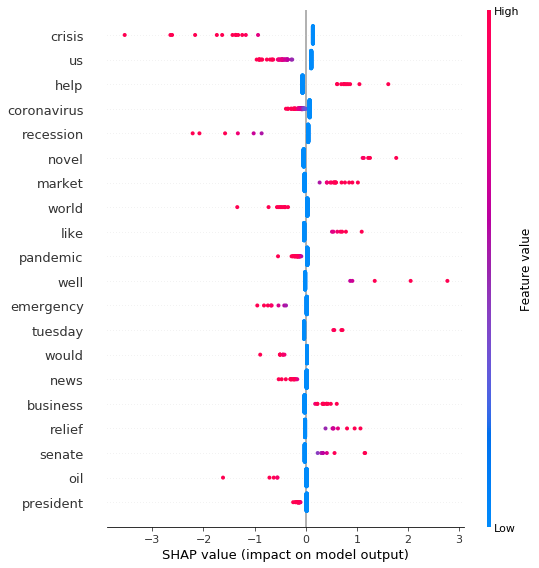

In [156]:
explainer = shap.LinearExplainer(model_final, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray()
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

# Examples of local explaination using SHAP

In [157]:
def draw_case(ind):
    shap.force_plot(
        explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
        feature_names=vectorizer.get_feature_names()
    )
    print("Sentiment:","Positive" if y_test.values[ind] else "Negative")
    print("Prediction:", "Positive" if y_pred[ind] else "Negative" )
    print("Description:")
    print(df.at[y_test.index[ind],'source'],' ',df.at[y_test.index[ind],'publishedAt'])
    print(df.at[y_test.index[ind],'description'])
    return ind

In [158]:
ind = draw_case(50)
shap.force_plot(
        explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
        feature_names=vectorizer.get_feature_names()
    )

Sentiment: Negative
Prediction: Negative
Description:
{'id': 'usa-today', 'name': 'USA Today'}   2020-03-23T11:57:00Z
For more than 20 years, Robert Kadlec has warned that the U.S. is not just vulnerable to a pandemic, but doomed by dysfunction if one were to strike.


In [159]:
ind = draw_case(16)
shap.force_plot(
        explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
        feature_names=vectorizer.get_feature_names()
    )

Sentiment: Negative
Prediction: Negative
Description:
{'id': 'business-insider', 'name': 'Business Insider'}   2020-03-21T13:15:00Z
Congress rolled out a new law that guarantees paid sick leave for workers affected by the coronavirus. It was the first time the US federal government has enacted any form of paid sick leave. But the law didn't cover independent contractors, which companies d…


In [160]:
ind = draw_case(28)
shap.force_plot(
        explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
        feature_names=vectorizer.get_feature_names()
    )

Sentiment: Positive
Prediction: Positive
Description:
{'id': 'business-insider', 'name': 'Business Insider'}   2020-03-25T18:56:53Z
Salesforce CEO Marc Benioff, known for his outspokenness on social and political issues, is urging everyone to take steps to stop the spread of the coronavirus. Benioff is calling on CEOs to take a 90 day "no layoff pledge" to help their employees through thi…


In [122]:
ind = draw_case(50)
shap.force_plot(
        explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
        feature_names=vectorizer.get_feature_names()
    )

Sentiment: Negative
Prediction: Negative
Description:
{'id': 'usa-today', 'name': 'USA Today'}   2020-03-23T11:57:00Z
For more than 20 years, Robert Kadlec has warned that the U.S. is not just vulnerable to a pandemic, but doomed by dysfunction if one were to strike.


In [125]:
ind = draw_case(52)
shap.force_plot(
        explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
        feature_names=vectorizer.get_feature_names()
    )

Sentiment: Negative
Prediction: Negative
Description:
{'id': 'reuters', 'name': 'Reuters'}   2020-03-25T16:04:00Z
Shut out of international capital markets and facing a further hit to its finances with the collapse in oil prices coming on top of U.S. sanctions, Iran is struggling to shield its economy from the coronavirus pandemic.


# eli5 Explaination

In [164]:
import eli5
eli5.show_weights(model_final, vec=vectorizer, top=50)

Weight?,Feature
+4.917,novel
+4.244,help
+3.578,well
+3.125,tuesday
+3.093,sell
+3.077,rescue
+2.948,gig
+2.826,interest
+2.818,growth
+2.740,state
